# Introducción al Deep Learning: fundamentos, arquitecturas y aplicaciones
## David de la Rosa de la Rosa (drrosa@ujaen.es)
## Manuel Germán Morales (mgerman@ujaen.es)

### Redes Neuronales: Introducción a la Inteligencia Artificial y Aprendizaje Profundo

En este cuaderno aprenderemos cómo crear un Autoencoder con Pytorch Lightning

In [1]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 831.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 50.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink

# Dataset: MNIST

Comenzamos como con los otros cuadernos, explorando el dataset con el que vamos a trabajar.

Vamos a seguir trabajando con imágenes. En el cuaderno de CNN utilizamos un dataset en el que aparecían varios objetos en imágenes RGB. Esta vez vamos a utilizar un dataset más sencillo, MNIST.

MNIST está formado por un conjunto de imágenes repartidas en 10 categorías. Cada categoría representa un número del 0 al 9. En las imágenes se ve escrito el número correspondiente.

Vamos a explorarlo un poco.

In [2]:
BATCH_SIZE = 64  # Tamaño de lote. Cuántas imágenes se procesan de forma simultánea.

In [3]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

# Definimos la transformación (convertir a tensor y normalizar de paso)
transform = transforms.ToTensor()

# Conjunto de entrenamiento
train_dataset = datasets.MNIST(
    root=".",
    train=True,
    transform=transform,
    download=True
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Conjunto de test
test_dataset = datasets.MNIST(
    root=".",
    train=False,
    transform=transform,
    download=True
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)  # Batch size 1 porque lo necesitaremos así para visualizar. Shuffle true para que a cada uno os salgan cosas diferentes

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 339kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.69MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.92MB/s]


In [4]:
# Podemos iterar sobre el conjunto de entrenamiento para ver algunas características del dataset
images, labels = next(iter(train_loader))
print("\n")
print(images.shape)
print(labels.shape)



torch.Size([64, 1, 28, 28])
torch.Size([64])


¿Recordáis qué significaban todos esos números, no?

Tamaño de lote 64
1 solo canal, lo que nos indica que es o blanco y negro o escala de grises
28, 28, las imágenes son de 28 píxeles de ancho y alto


Podemos visualizar algunas imágenes

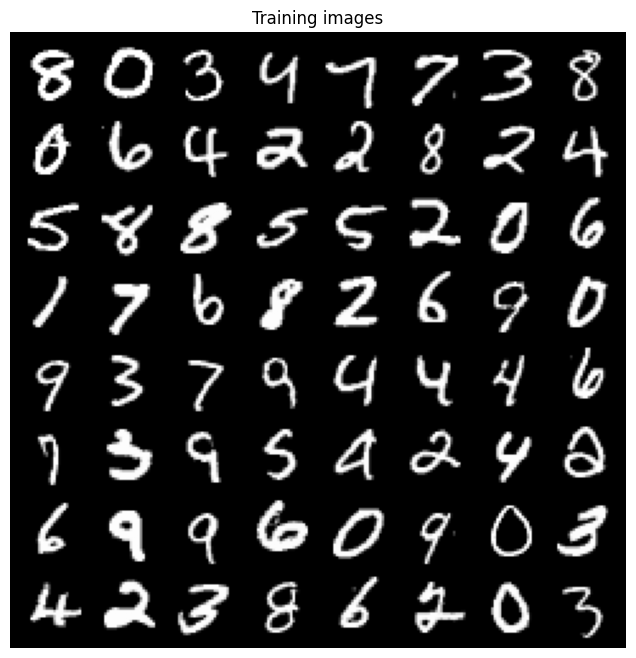

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Obtenemos un batch de imágenes
images, labels = next(iter(train_loader))

# Pintamos 64 imágenes en un grid 8x8
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64],
    padding=2,
    normalize=True),
    (1, 2, 0)))
plt.show()

# Construcción de un AE y propiedades del espacio latente

Comenzamos por la parte sencilla, construir un Autoencoder.

Ya sabemos programar una red neuronal (sesión 2) y también sabemos cómo programar una red neuronal convolucional (sesión 3). Un autoencoder no es más que una red neuronal (convolucional en este caso que vamos a trabajar con imágenes, pero podría no serlo) con una arquitectura algo más peculiar, pero la forma de programarlo es idéntica.

Vamos a empezar programando el encoder. Este bloque tomará como entrada las imágenes de 28x28 y las codificará, transformándolas a la dimensión dada por el espacio latente.

Vamos a verlo paso a paso en el código...

In [6]:
# Imports
import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import matplotlib.pyplot as plt

In [7]:
# Encoder

# Hereda de nn.Module de Pytorch. Aún no usamos pytorch Lightning
class Encoder(nn.Module):

  # El constructor va a recibir la dimensión del espacio latente, aunque podríamos ponerla directamente en el código, a gusto del programador
  def __init__(self, latent_dim):
    super().__init__()

    # Dentro del constructor definimos el modelo como nn.Sequential
    self.encoder = nn.Sequential(

      # Primera convolución
      # Input: [batch_size, 1, 28, 28]
      nn.Conv2d(1, 16, 4, stride=2, padding=1),  # Output: [batch_size, 1, 14, 14]
      nn.ReLU(),

      # Segunda convolución
      nn.Conv2d(16, 32, 4, stride=2, padding=1),  # Output: [batch_size, 32, 7, 7]
      nn.ReLU(),

      # Aplanamos antes de conectarlo a una capa lineal
      nn.Flatten(),

      # Nos llegan dimensiones [32, 7, 7]. Todas esas características las conectamos a una capa densa
      nn.Linear(32 * 7 * 7, latent_dim),
    )


  # Método forward
  def forward(self, x):
    return self.encoder(x)

El decoder sigue la misma idea. Recibe como entrada un tensor de dimensiones "latent_dim", la salida del encoder. Su objetivo es reconstruir ese vector hasta tener las mismas dimensiones que la entrada original, con una arquitectura simétrica al encoder (pero agrandando con Conv2dTranspose, en lugar de achicar con Conv2d).

In [8]:
# Decoder

class Decoder(nn.Module):

  def __init__(self, latent_dim):
    super().__init__()

    self.decoder = nn.Sequential(
      nn.Linear(latent_dim, 32 * 7 * 7),
      nn.ReLU(),
      nn.Unflatten(1, (32, 7, 7)),
      nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # 16x14x14
      nn.ReLU(),
      nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),   # 1x28x28
      nn.Sigmoid(),
    )

  def forward(self, x):
    return self.decoder(x)

Es importante recalcar que, a diferencia de la práctica anterior, esta vez hemos "achicado" la entrada con la propia capa convolucional, y la agrandamos con conv2dTranspose. Estos pasos se podrían haber hecho utilizando capas MaxPooling (para achicar) y UpSampling (para agrandar). Cada opción tiene sus ventajas e inconvenientes. Por ejemplo, al hacerlo mediante convoluciones permitimos que el "achicar" y "agrandar" sean procesos que la red también aprende, en lugar de ser una simple operación matemática. Por otro lado, hay artículos que afirman que hacerlo así hace que se formen artefactos indeseados en la imagen.

Como siempre, hay que probar y validar el método que vayamos a utilizar en nuestor método final. En este caso, para que tengáis una referencia de cómo se puede hacer de las dos maneras, lo haremos así.

Teniendo el encoder y decoder, definimos nuestro módulo Pytorch Lightning.

In [9]:
# Módulo Pytorch Lightning
class LitConvAutoEncoder(pl.LightningModule):

    # Recibe como entrada el encoder y decoder
    def __init__(self, encoder, decoder):

        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    # Método forward, codifica y decodifica la entrada
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    # En el proceso de entrenamiento, la pérdida se calcula como la diferencia entre la imagen original y su reconstrucción
    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self(x)
        loss = nn.functional.mse_loss(x_hat, x)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    # Establecemos también el learning rate
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


Definimos el proceso de interpolación.

Consiste en:

1. Codificar algunas imágenes (del conjunto de test)
2. Formar pares entre las imágenes
3. Interpolar linealmente las imágenes. Buscar los vectores latentes que hay "entre las dos imágenes"
4. Decodificar las interpolaciones
5. Ver si tiene sentido lo que hace


No hace falta entrar en profundidad a ver el código

In [10]:
# Definimos el proceso de interpolación


def interpolate(model, device, n_examples=5):

    # Model.eval para indicar que estamos en modo evaluación (desactivaría dropout, batchnorm,...)
    model.eval()
    data = datasets.MNIST(root=".", train=False, transform=transforms.ToTensor())
    loader = DataLoader(data, batch_size=1, shuffle=True)

    pairs = []
    zs = []

    # Se cogen imágenes de test, se codifican y se guarda el tensor en el espacio latente
    for img, _ in test_loader:
        img = img.to(device)
        z = model.encoder(img)
        zs.append(z)
        pairs.append(img)
        if len(pairs) == 2 * n_examples:  # Condición de parada
            break

    fig, axs = plt.subplots(n_examples, 10, figsize=(15, 2 * n_examples))

    # Se buscan interpolaciones entre pares
    for i in range(n_examples):

        # Cogemos dos vectores del espacio latente
        z1, z2 = zs[2*i], zs[2*i + 1]
        interpolations = []

        # Generamos 10 interpolaciones lineales
        for alpha in torch.linspace(0, 1, steps=10):
            z = (1 - alpha) * z1 + alpha * z2

            # Las interpolaciones se pasan por el decoder
            interp_img = model.decoder(z).detach().cpu().view(28, 28)
            interpolations.append(interp_img)

        for j, img in enumerate(interpolations):
            axs[i, j].imshow(img, cmap="gray")
            axs[i, j].axis("off")

    plt.tight_layout()
    plt.show()

Tenemos ya todo preparado para entrenar nuestro primer autoencoder...

In [11]:
# Semilla
pl.seed_everything(2025)

# Creamos el encoder y decoder
encoder = Encoder(latent_dim=16)
decoder = Decoder(latent_dim=16)

# Creamos nuestro módulo lightning
model = LitConvAutoEncoder(encoder, decoder)

# Entrenamos durante diez épocas
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto",
)

trainer.fit(model, train_loader)

INFO:lightning_fabric.utilities.seed:Seed set to 2025
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 33.6 K | train
1 | decoder | Decoder | 31.4 K | train
--------------------------------------------
65.0 K    Trainable params
0         Non-trainable params
65.0 K    Total params
0.260     Total estimated model params size (MB)
17        Modules in train mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


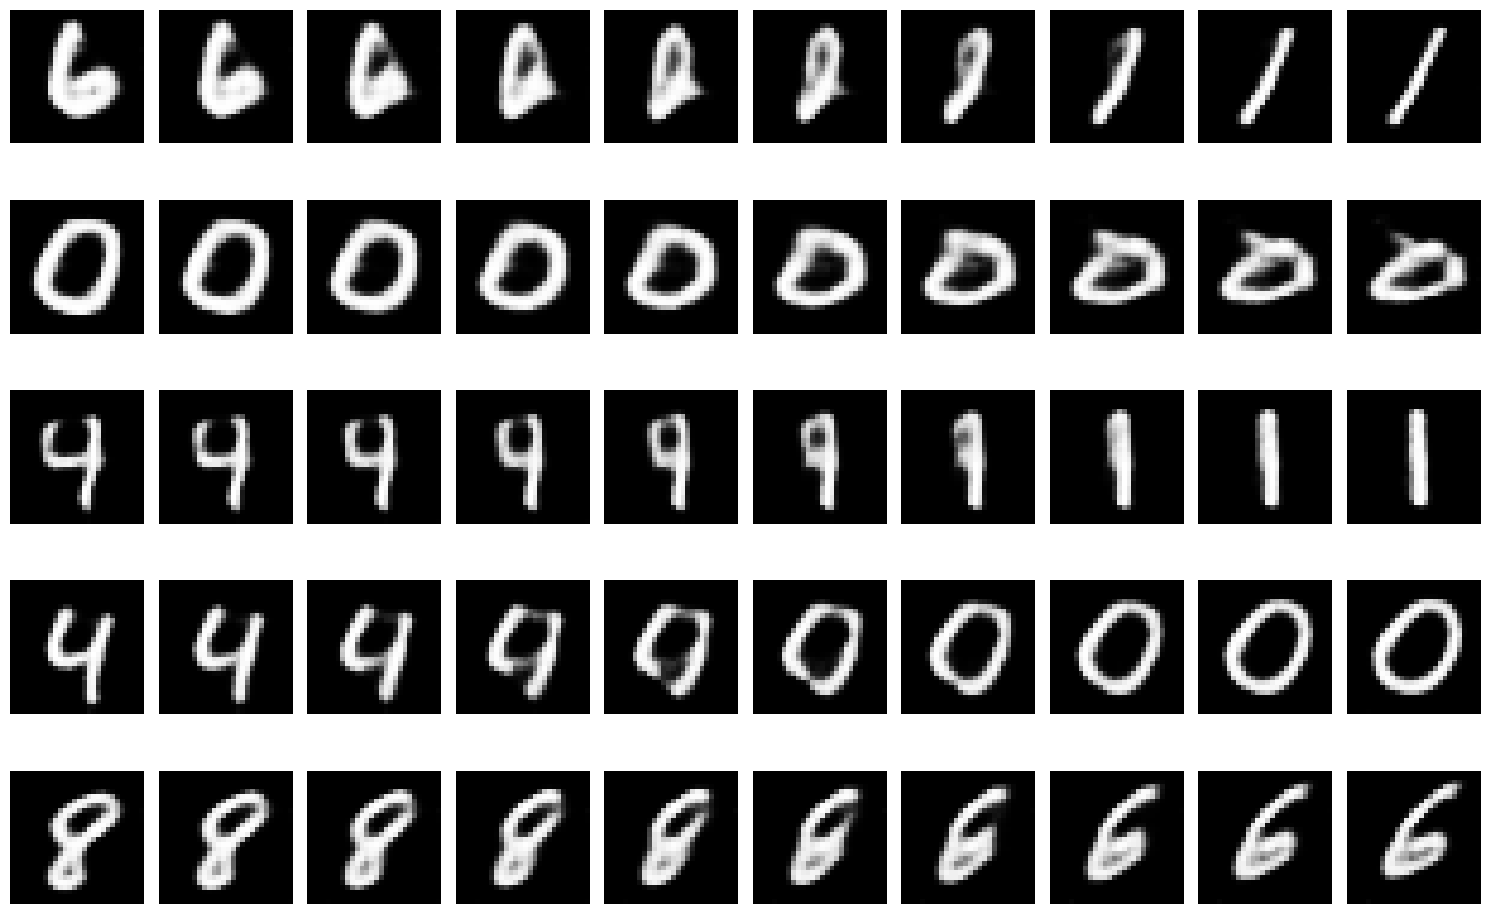

In [15]:
    # Interpolación
    interpolate(model.to("cuda" if torch.cuda.is_available() else "cpu"), model.device, n_examples=5)

¿Tienen sentido las interpolaciones? Sí. Sigue un paso lógico del primer dígito al segundo. Esto nos indica que el espacio latente está bien organizado, no hay saltos raros entre números, ni huecos que no representen nada.

Esto que hemos hecho lo hemos conseguido porque estamos ante un dataset muy sencillo. Para datasets más complejos hay que hacer más complejo el autoencoder (usar otro tipo como Variational Autoencoder, hacerlo más grande, entrenarlo durante más épocas,...)

# Denoising

Otra de las cosas que se podían hacer con un autoencoder es eliminar ruido de las imágenes. Vamos a verlo funcionando!

Para este caso, en lugar de utilizar directamente el dataset MNIST vamos a usar una variante ruidosa. Simplemente creamos una clase que redefina el método getitem de MNIST para que nos devuelva tanto la imagen original como una imagen con ruido.

In [16]:
# Dataset MNIST con ruido
class NoisyMNIST(datasets.MNIST):
    def __getitem__(self, index):
        img, target = super().__getitem__(index)

        noise = torch.randn_like(img) * 0.5
        noisy_img = torch.clamp(img + noise, 0., 1.)
        return noisy_img, img  # [1, 28, 28]

In [17]:
# Transformaciones
transform = transforms.ToTensor()

# Loaders
train_ds = NoisyMNIST(root=".", train=True, download=True, transform=transform)
test_ds = NoisyMNIST(root=".", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 343kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.13MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.15MB/s]


Tenemos que reescribir el método lightning.

En un AE normal, la diferencia se calcula entre la imagen original y su reconstrucción. En el caso de un denoising autoencoder, la diferencia se calcula entre la reconstrucción de la imagen ruidosa y la imagen original sin ruido. Así forzamos a que la red aprenda a eliminar el ruido, al comparar la reconstrucción no con la original (ruidosa) sino con la imagen sin ruido y utilizar ese valor como función de pérdida

In [18]:
# Definimos nuestro método Lightning
class DenoisingAutoencoder(pl.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder



    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

    # La principal diferencia la tenemos en el training_step
    def training_step(self, batch, batch_idx):
        noisy_imgs, clean_imgs = batch
        reconstructed = self(noisy_imgs)  # Reconstruimos a partir de imágenes con ruido
        loss = nn.functional.mse_loss(reconstructed, clean_imgs)  # Calculamos la pérdida entre las reconstrucciones y las imágenes SIN ruido
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return loss


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [19]:
# Entrenamos el modelo
encoder = Encoder(latent_dim=64)
decoder = Decoder(latent_dim=64)
model = DenoisingAutoencoder(encoder, decoder)
trainer = pl.Trainer(max_epochs=5)
trainer.fit(model, train_loader)

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 108 K  | train
1 | decoder | Decoder | 106 K  | train
--------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.862     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Vamos a poner a prueba nuestro denoiser...

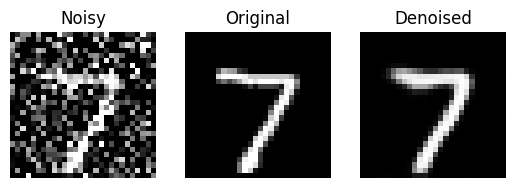

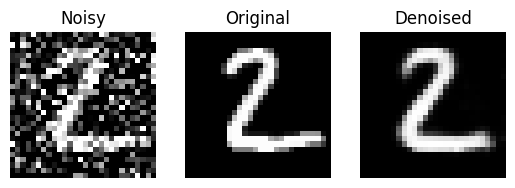

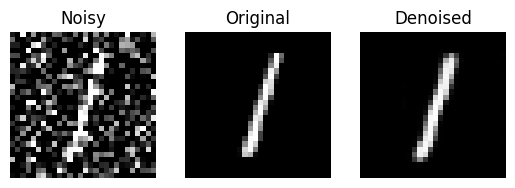

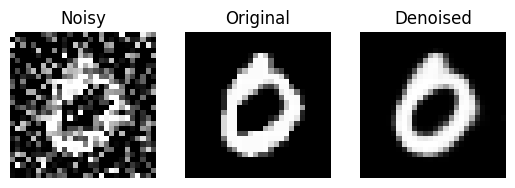

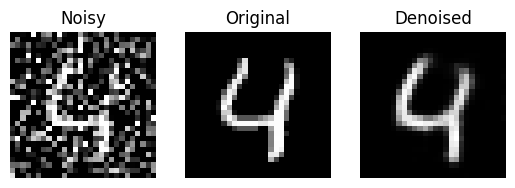

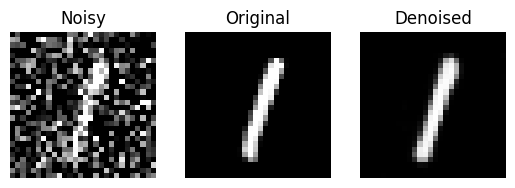

In [20]:
import matplotlib.pyplot as plt

# Mostrar imágenes ruidosas vs reconstruidas
model.eval()
noisy_imgs, clean_imgs = next(iter(test_loader))
with torch.no_grad():
    output = model(noisy_imgs)

# Mostrar
for i in range(6):
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(noisy_imgs[i][0], cmap='gray')
    axs[0].set_title("Noisy")
    axs[1].imshow(clean_imgs[i][0], cmap='gray')
    axs[1].set_title("Original")
    axs[2].imshow(output[i][0], cmap='gray')
    axs[2].set_title("Denoised")
    for ax in axs:
        ax.axis('off')
    plt.show()

¡Funciona! A la derecha tenemos las imágenes ruidosas, en medio las imágenes originales. El autoencoder coge las imágenes ruidosas, las codifica y decodifica y, en ese proceso, a aprendido a eliminar por completo el ruido de la imagen.